**TODO**
- create a better control stuc for internal parameters to, look as SKiDl's lib file that does the conversion from SKiDl to pyspice for inspiration

In [1]:
#Library import statements

from skidl.pyspice import *
#can you say cheeky 
import PySpice as pspice
#becouse it's written by a kiwi you know
import lcapy as kiwi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from IPython.display import YouTubeVideo, display

import traceback

In [2]:
#notebook specific loading control statements 
%matplotlib inline
#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

Software,Version
Python,3.7.6 64bit [GCC 7.3.0]
IPython,7.12.0
OS,Linux 4.19.104 microsoft standard x86_64 with debian bullseye sid
skidl,0.0.31.dev0
PySpice,1.4.3
lcapy,0.75.dev0
sympy,1.6.2
numpy,1.18.1
matplotlib,3.3.0
pandas,1.1.4


In [3]:
#import the op read tool from last subchapter
from DC_1_Codes import op_results_collect

# Working with SKiDl elements

The following example, to be honest, is pedantic; but it serves to introduce the current source in SPICE which can be a real headache. It also shows how to let Python do the work of interacting with elements that we will readily make great use of down the road.

So why is thus so pedantic? source transformations are mostly an analytic simplification tool. And while yes there is some practicality in being able to find a matching current source to a voltage source and vice versa with equivalent power from the standpoint of Thevenin and Norton's theorem. There are, however, serious limation with how the real circuits handle inputs of voltage and current differently. And frankly, from SPICE’s point of view for this exercise, it doesn't care, it's going to solve regardless. So if you need a refresher on source transformations with an illustration of why there a really great analytical tool please watch ALL ABOUT ELECTRONICS YT video on "Source Transformations" where this example is pulled from.


## Example 1 from "Source Transformation" @ ~6:30 min 

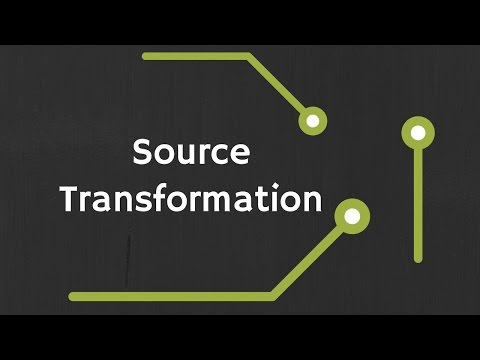

In [4]:
YouTubeVideo('FtEU5ZoO-fg', width=500, height=400, start=390)

### A very important word about current source in SPICE

Before building the circuit above a word about any current sources in SPICE. Recalling the discussion around the surefire method of measuring currents in SPICE using a 0V Liner Voltage Souce (aka the SPICE ammeter trick) in SPICE current flow is in the positive direction from a positive voltage to a negative voltage. So by convention, we draw independent and dependent sources with an arrow in the direction of how current is being added. While that means that all current sources are polarized such that the positive terminal is at the tail of the drawn current arrow and the head is the negative terminal. When you use a schematic editor with built-in SPICE it does all the terminal work in the background. But when we are indirectly working with netlist, via SKiDL, you will have to make sure you remember this. Or else this will bite you in the butt and keep costing you time till have this arrow and terminal connection for current ingrained into you.

In [5]:
reset()
vs_4=V(ref='s_4', dc_value=4@u_V)
vs_8=V(ref='s_8', dc_value=8@u_V)
cs_2=I(ref='s_2', dc_value=2@u_A)
r1=R(ref='1', value=6@u_Ohm)
r2=R(ref='2', value=12@u_Ohm)
r3=R(ref='3', value=12@u_Ohm)

(gnd&vs_4['p', 'n']&r1) |r2 

vs_8['p', 'n']+=r2[2], r3[2]

(gnd & cs_2 | r3)

circ=generate_netlist()
print(circ)

preop_sim=op_results_collect(circ)
#store the results for comperasion to post souce transfromations
pre_tf_res=preop_sim.results_df
pre_tf_res

.title 
Vs_4 0 N_1 4V
Vs_8 N_2 N_3 8V
Is_2 0 N_3 2A
R1 N_1 N_2 6Ohm
R2 0 N_2 12Ohm
R3 0 N_3 12Ohm




No errors or warnings found during netlist generation.



,Item_Type,Value,Unit
Circ_Item,,,
N_1,Node_Voltage,-4,V
N_2,Node_Voltage,6,V
N_3,Node_Voltage,-2,V
Vs_4,Branch_Curr,1.66667,A
Vs_8,Branch_Curr,2.16667,A


### SKiDl's Diabetic Syntax `&`, `|`

Notice above that usage of Pythons logical AND operator & and logical OR operator | in creating the circuit. Since & and | are just operators in python we can do what is called operator extensions to them to make them act in special ways in a certain context. In SKiDls particular case the logical and (&) is a shorthand for putting two elements in series. And the logical OR (|) is shorthand for putting two elements in parral. Furthermore, these operators and parentheses sensitive, and are not polarized sensitive and so polarized elements need to have their terminals called out when using the. There called Diabetic Syntical Suger in light of their release announcement entitled ["SWEETENING SKIDL"](http://xess.com/skidl/docs/_site/blog/sweetening-skidl). Using is up to your codding style and that of your colleagues. All joking aside they are extremely useful operators to know how to use, and we will use them in this book.

### Crafting the transfomation tool

We are not going into that much detial about these tool. The important thing is that we can take advante that all our elements (SKiDl part) and nets are objects in Python. And therefore have methods and attriputs that are accesable and therefore more usable then helping produce part of a line of a SPICE netlist. For instiance Voltage and Current souce store there dcvalue in `<V\I>.dc_value` where resitors store there resistince in `R.value`.This then alows us to use the elements to perform calculation outside of SPICE and even better assisit in creating new elements as we have done below.

In [6]:
#%%writefile -a DC_1_Codes.py
#chapter 1 section 2 get_skidl_spice_ref function
#used for getting the name of the element as it would appear in a
#generated netlist

def get_skidl_spice_ref(skidle_element):
    """
    Helper function to retrieve SKiDL element name as appears in the final netlist
    
    Args:
        skidle_element (skidl.part.Part): SKiDl part to get the netlist name from
    
    Returns:
        returns a string with the netlist name of `skidle_element`, or throws an
        error if `skidle_element` is not a SKiDl part
    
    """
    assert repr(type(skidle_element))=="<class 'skidl.part.Part'>", '`skidle_element` must be a SKiDl part'
    
    if skidle_element.ref_prefix!=skidle_element.ref[0]:
        return skidle_element.ref_prefix+skidle_element.ref
    else:
        return skidle_element.ref

In [7]:
#%%writefile -a DC_1_Codes.py
#chapter 1 section 2 dc_cs2vs function
#creates a voltage source element to the current source based on the 
#value if the input DC current element and it's parallel resistor
#via the source transformation rules

def dc_cs2vs(dc_cs, cs_par_res):
    """
    Create a new equivalent voltage source to the current source with parallel resistance
    Args:
        dc_cs (SKiDl current source): the current source to transform to a voltage source
        cs_par_res (SKiDl resistor): the parrel resistor to the current source to be transformed
    
    Returns:
        returns an equivalent DC voltage source element to the current source based on the 
        value if the input DC current element and it's parallel resistor via the source transformation rules 
    
    TODO:
        -figure out how to do assertion check that cs_par_res is in parallel to dc_cs
        
    Future:
        -make into subcircuit with net inputs to automatically add the new source and resistance to the circuit
    """
    
    #do assertion checks to insure that passed in objects are what they are supposed to be
    assert dc_cs.ref_prefix=='I', '<dc_cs> was not a current source'
    assert cs_par_res.ref_prefix=='R', '<cs_par_res> was not a resistor'
    
    
    old_maxpower=float((dc_cs.dc_value**2)*cs_par_res.value)
    new_vs_val=float(dc_cs.dc_value*cs_par_res.value)
    assert np.around(float(new_vs_val*dc_cs.dc_value), 6)==np.around(old_maxpower, 6), "Um, something wrong since before and after max power not equal"
    
    new_vs_ref=dc_cs.ref
    if new_vs_ref[0]!='I':
        new_vs_ref='I'+new_vs_ref
    
    
    new_vs_ref=f"V{new_vs_ref[1:]}_f_{new_vs_ref}"
    print(new_vs_ref)
    
    
    eq_vs=V(dc_value=new_vs_val@u_V, ref=new_vs_ref)
    warnings.warn(f"""New voltage source values: {new_vs_val} [V] with max aviabel power {old_maxpower} [W] \n transformed creation statment will be like: \n`(gnd & <eq_vs>['n', 'p'] & <cs_par_res>)`""")
    
    return eq_vs

In [8]:
#%%writefile -a DC_1_Codes.py
#chapter 1 section 2 dc_vs2cs function
#creats current source element to the voltage source based on the 
#value if the input DC current element and it's series resistor
#via the source transformation rules

def dc_vs2cs(dc_vs, vs_ser_res):
    """
    Create a new equivalent current source to voltage source with series resistance
    Args:
        dc_vs (SKiDl voltage source): the voltage source to transform to a current source
        vs_ser_res (SKiDl resistor): the serries resistor to the voltage source to be transformed
    
    Returns:
    
    TODO:
        -figure out how to do assertion check that vs_ser_res is in serries to dc_vs
    
    Future:
        -make into subcircuit with net inputs to automatically add the new source and resistance to the circuit
    """
    
    #do assertion checks to insure that passed in objects are what they are supposed to be
    assert dc_vs.ref_prefix=='V', '<dc_vs> was not a voltage source'
    assert vs_ser_res.ref_prefix=='R', '<vs_ser_res> was not a resistor'
    
    old_maxpower=float((dc_vs.dc_value**2)/vs_ser_res.value)
    new_cs_val=float(dc_vs.dc_value/vs_ser_res.value)
    assert np.around(float(new_cs_val*dc_vs.dc_value), 6)==np.around(old_maxpower, 6), "Um, something wrong since before and after max power not equal"


    new_cs_ref=dc_vs.ref
    if new_cs_ref[0]!='V':
        new_cs_ref='V'+new_cs_ref
    
    
    new_cs_ref=f"I{new_cs_ref[1:]}_f_{new_cs_ref}"
    #print(new_cs_ref)
    
    
    eq_cs=I(dc_value=new_cs_val@u_A, ref=new_cs_ref)# might still need this: , circuit=vs_ser_res.circuit)

    warnings.warn(f"""New current source values: {new_cs_val} [A] with max aviabel power {old_maxpower} [W] \n transformed creation statment will be like:\n `(gnd & <eq_cs>['n', 'p'] | <vs_ser_res>)` \n""")
    
    return eq_cs


### validate the transform¶

For this, we are to transform the left voltage source and series resistors and the right current source and parral resistor simultaneously which halfway deviates from what ALL ABOUT ELECTRONICS did working the example analytically. We will have the center parallel resistor and voltage source as a reference network.

In [9]:
reset()
r1=R(ref='1', value=6@u_Ohm)
r2=R(ref='2', value=12@u_Ohm)
r3=R(ref='3', value=12@u_Ohm)

vs_8=V(ref='s_8', dc_value=8@u_V)

cs_4_f_cs_4=dc_vs2cs(vs_4, r1)

vs_2_f_cs_2=dc_cs2vs(cs_2, r3)


(gnd&cs_4_f_cs_4['n', 'p']|r1) |r2 

vs_8['p', 'n']+=r2[2], r3[2]

(gnd & vs_2_f_cs_2['n', 'p'] & r3)

circ=generate_netlist()
print(circ)


postop_sim=op_results_collect(circ)
#store the results for comperaion to pre souce transfromations
post_tf_res=postop_sim.results_df
post_tf_res

/home/iridium/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: New current source values: 0.6666666666666666 [A] with max aviabel power 2.6666666666666665 [W] 
 transformed creation statment will be like:
 `(gnd & <eq_cs>['n', 'p'] | <vs_ser_res>)` 

/home/iridium/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: New voltage source values: 24.0 [V] with max aviabel power 48.0 [W] 
 transformed creation statment will be like: 
`(gnd & <eq_vs>['n', 'p'] & <cs_par_res>)`

No errors or warnings found during netlist generation.



Vs_2_f_Is_2
.title 
R1 0 N_1 6Ohm
R2 0 N_1 12Ohm
R3 N_3 N_2 12Ohm
Vs_8 N_1 N_2 8V
Is_4_f_Vs_4 N_1 0 0.6666666666666666A
Vs_2_f_Is_2 N_3 0 24.0V



,Item_Type,Value,Unit
Circ_Item,,,
N_1,Node_Voltage,6,V
N_3,Node_Voltage,24,V
N_2,Node_Voltage,-2,V
Vs_8,Branch_Curr,2.16667,A
Vs_2_f_Is_2,Branch_Curr,2.16667,A


Since we stored the results from the pre transformed circuit we can try to do an eyeball compersion between the two dataframes, however, since the net names are no longer the same we only can look at the branch current of vs_8 which remained constant

In [10]:
pre_tf_res

,Item_Type,Value,Unit
Circ_Item,,,
N_1,Node_Voltage,-4,V
N_2,Node_Voltage,6,V
N_3,Node_Voltage,-2,V
Vs_4,Branch_Curr,1.66667,A
Vs_8,Branch_Curr,2.16667,A


In [11]:
(pre_tf_res.loc[get_skidl_spice_ref(vs_8)]==post_tf_res.loc[get_skidl_spice_ref(vs_8)]).all()

True

Thus we can assume that the circuits are source equivalents of each other, but this book is about cultivating analog design verification. And assuming can yield performance hits and even worse the need for a SPIN. Therefore DONT ASSUME, figure out a way to VERIFY via Quantifiable answers.

## internal parameters:

ngspice (in fact most SPICE engines) elements have what are called internal parameters. Most of the setup parameters like dc_value, resistance, ect along with nitty-gritty parameters for more advanced SPICE simulations that will get too. What we are after of now are the internal values that store results of simulations as we have alluded to in the non surefire way to save internal parameters. For instance, resistors have a way of measuring the internal current flowing through them the but the caveat is that it only returns real values in ngspice, which will be an issue when doing AC simulations. But for DC simulations is a tool we should utilize. Also at the time of writing this PySPICE has a quark that internal values are not retrieved at the same time the branch currents and net voltages are. So to get both the simulation has to be run twice and the author is not sure if this is quark of ngspice or PySPICE but the author will look into it at a later time.

For now, just know internal parameters have a string calls of `<Elelement name>@[<internal paamamater>]` that is passed to a PySPICE simulation objects `.save_internal_parameters` method and then are returned in the results as the original string call to the results super dictionary.


In [12]:
#%%writefile -a DC_1_Codes.py
#chapter 1 section 2 op_internal_ivp class
# class to get both the branch currents and node voltages,
# along with the internal parameters values for 
# DC operating point analysis

class op_internal_ivp():
    """
    Class for creating a SPICE simulation on the whole circuits internal parameters for current, voltage, and power
    for dc operating point (.op) simulations. Will only collect internal parameters and not global voltage and currents 
    of the circuit
    TODO:
        Make this inheritable from op_results_collect 
    """
    def __init__(self, op_sim_circ, display_results=False):
        """
        Basic class to get pyspice operating_point (ngspice `.op`) simulation results
        for internal parameters for Resistors, Current Source, Voltage Source current, voltage, power
        respectively
        
        
        Args:
            op_sim_circ (pspice.Spice.Netlist.Circuit): the Netlist circuit produced 
            from SKiDl's `generate_netlist()`
            
            display_results (bool; False): option to have the simulation results
                stored in `self.results_df` automatically displayed from a jupyter notebook
                ell
        
        Returns:
            will create a simulation in `self.op_sim`, raw results of dc operating 
            point simulation will be stored in `self.op_sim_results`, the tablized
            results will be stored in pandas dataframe `self.results_df`
        
        TODO: 
            - add kwargs to the simulator
            - add an assertion that only a pyspice netlist circuit obj can
                    be passed into op_sim_circ
            
        """
        #need to add assertions for op_sim_circ ==pspice.Spice.Netlist.Circuit
        
        #store the circuit internally
        self.op_sim_circ=op_sim_circ
        #create the sim obj
        self.op_sim=self.op_sim_circ.simulator()
        
        #store bool to display results dataframe
        self.display_results=display_results
        
        #create the internal parameters to save
        self.create_savable_items()
        #run the sim for .op for internal parameters and record results
        self.sim_and_record()
        
    def create_savable_items(self):
        """
        Helper method to create a listing of internal parameters and the table of the results.
        Right now only creates savable internal parameters for:
        Linear Dependent Voltage Sources: current, power
        Linear Dependent Current Sources: current, voltage, power
        Standard Resistor: current, voltage, power
        Linear Dependent Current Sources: current, voltage, power
        VCCS: current, voltage, power
        VCVS: current, voltage, power
        CCVS: current, voltage, power
        CCCS:currrent, voltage, power
        
        See ngspice manual typically chapter 31 "Model and Device Parameters"
        for more deitals about deice intiernal parmaters

        """
        self.results_df=pd.DataFrame(columns=['Circ_Item', 'Item_Type', 'Value', 'Unit'])
        self.results_df.set_index('Circ_Item', drop=True, append=False, inplace=True, verify_integrity=False)
        
        #helper row creation statement
        def add_row(index, unit): 
            self.results_df.at[index, ['Item_Type', 'Unit']]=['internal', unit]
            
        
        for e in self.op_sim_circ.element_names:
            """
            Ref: ngspice documentation chapter 31 (typically): Model and Device Parameters
                
            """
            #resistors
            if e[0]=='R':
                add_row(f'@{e}[i]', 'A')
                add_row(f'@{e}[p]', 'W')
            
            #independnt current source
            elif e[0]=='I':
                add_row(f'@{e}[c]', 'A')
                add_row(f'@{e}[v]', 'V')
                add_row(f'@{e}[p]', 'W')
            
            #independ Voltage source
            elif e[0]=='V':
                add_row(f'@{e}[i]', 'A')
                add_row(f'@{e}[p]', 'W')
            
            #controlled sources
            elif e[0] in ['F', 'H', 'G', 'E']:
                add_row(f'@{e}[i]', 'A')
                add_row(f'@{e}[v]', 'V')
                add_row(f'@{e}[p]', 'W')
            
            else:
                warnings.warn(f"Circ Element {e} is not setup to have internals read, skiping")
                
    def sim_and_record(self):
        """
        run the .op simulation and get the internal values 
        
        Args: None
        Returns:
            `self.internal_opsim_res` store the raw results of the .op for internal pamtyers
            whereas `self.results_df` stores the pandas dataframe of internal parameters results
        
        TODO: figure out how to do this at the same time as the main node branch sim
            this doing separately is getting old
        """
        save_items=list(self.results_df.index)
        self.op_sim.save_internal_parameters(*save_items)
        self.internal_opsim_res=self.op_sim.operating_point()
        
        for save in save_items:
            self.results_df.at[save, 'Value']=self.internal_opsim_res[save].as_ndarray()[0]
        
        if self.display_results:
            print('.op sim internal parmter results')
            display(self.results_df)



### pre transform_internals

In [13]:
reset()
vs_4=V(ref='s_4', dc_value=4@u_V)
vs_8=V(ref='s_8', dc_value=8@u_V)
cs_2=I(ref='s_2', dc_value=2@u_A)
r1=R(ref='1', value=6@u_Ohm)
r2=R(ref='2', value=12@u_Ohm)
r3=R(ref='3', value=12@u_Ohm)

(gnd&vs_4['p', 'n']&r1) |r2 

vs_8['p', 'n']+=r2[2], r3[2]

(gnd & cs_2 | r3)

circ=generate_netlist()
print(circ)



.title 
Vs_4 0 N_1 4V
Vs_8 N_2 N_3 8V
Is_2 0 N_3 2A
R1 N_1 N_2 6Ohm
R2 0 N_2 12Ohm
R3 0 N_3 12Ohm




No errors or warnings found during netlist generation.



In [14]:
preop_ivp_sim=op_internal_ivp(circ)
pre_ivp_res=preop_ivp_sim.results_df
pre_ivp_res

Unit is None for @is_2[p] power


Unit is None for @r1[p] power


Unit is None for @vs_4[p] power


Unit is None for @vs_8[p] power


Unit is None for @r2[p] power


Unit is None for @r3[p] power


,Item_Type,Value,Unit
Circ_Item,,,
@Vs_4[i],internal,-1.66667,A
@Vs_4[p],internal,6.66667,W
@Vs_8[i],internal,-2.16667,A
@Vs_8[p],internal,17.3333,W
@Is_2[c],internal,2,A
@Is_2[v],internal,-2,V
@Is_2[p],internal,4,W
@R1[i],internal,-1.66667,A
@R1[p],internal,16.6667,W


### post transform internals

In [15]:
reset()
r1=R(ref='1', value=6@u_Ohm)
r2=R(ref='2', value=12@u_Ohm)
r3=R(ref='3', value=12@u_Ohm)

vs_8=V(ref='s_8', dc_value=8@u_V)

cs_f_vs_4=dc_vs2cs(vs_4, r1)

vs_f_cs_2=dc_cs2vs(cs_2, r3)


(gnd&cs_f_vs_4['n', 'p']|r1) |r2 

vs_8['p', 'n']+=r2[2], r3[2]

(gnd & vs_f_cs_2['n', 'p'] & r3)

circ=generate_netlist()
print(circ)

Vs_2_f_Is_2
.title 
R1 0 N_1 6Ohm
R2 0 N_1 12Ohm
R3 N_3 N_2 12Ohm
Vs_8 N_1 N_2 8V
Is_4_f_Vs_4 N_1 0 0.6666666666666666A
Vs_2_f_Is_2 N_3 0 24.0V



/home/iridium/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: New current source values: 0.6666666666666666 [A] with max aviabel power 2.6666666666666665 [W] 
 transformed creation statment will be like:
 `(gnd & <eq_cs>['n', 'p'] | <vs_ser_res>)` 

/home/iridium/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: New voltage source values: 24.0 [V] with max aviabel power 48.0 [W] 
 transformed creation statment will be like: 
`(gnd & <eq_vs>['n', 'p'] & <cs_par_res>)`

No errors or warnings found during netlist generation.



In [16]:
postop_ivp_sim=op_internal_ivp(circ)
post_ivp_res=postop_ivp_sim.results_df
post_ivp_res

Unit is None for @vs_2_f_is_2[p] power


Unit is None for @r2[p] power


Unit is None for @r1[p] power


Unit is None for @vs_8[p] power


Unit is None for @is_4_f_vs_4[p] power


Unit is None for @r3[p] power


,Item_Type,Value,Unit
Circ_Item,,,
@R1[i],internal,-1,A
@R1[p],internal,6,W
@R2[i],internal,-0.5,A
@R2[p],internal,3,W
@R3[i],internal,2.16667,A
@R3[p],internal,56.3333,W
@Vs_8[i],internal,-2.16667,A
@Vs_8[p],internal,17.3333,W
@Is_4_f_Vs_4[c],internal,0.666667,A


### Quantitive comparison ¶
Since our results are stored in Pandas dataframes we can make use of the power of Pandas to do data analysis to get insight into what is going on. Where below we get a merger of the two dataframes side by side for all the elements that remained the same in the circuit pre and post-transformation. And we then follow that up with color-coding of what values remained the same between the pre and post-transformation of the circuit


In [17]:
pre_post_comp=pd.concat([pre_ivp_res, post_ivp_res], join='inner',  axis='columns', keys=['Pre', 'Post'])
pre_post_comp

Pre                     Post              
          Item_Type     Value Unit Item_Type    Value Unit
Circ_Item                                                 
@Vs_8[i]   internal  -2.16667    A  internal -2.16667    A
@Vs_8[p]   internal   17.3333    W  internal  17.3333    W
@R1[i]     internal  -1.66667    A  internal       -1    A
@R1[p]     internal   16.6667    W  internal        6    W
@R2[i]     internal      -0.5    A  internal     -0.5    A
@R2[p]     internal         3    W  internal        3    W
@R3[i]     internal  0.166667    A  internal  2.16667    A
@R3[p]     internal  0.333333    W  internal  56.3333    W

In [18]:
def color_results(row):    
    is_equal=(row['Pre']==row['Post']).all()    
    if is_equal:
        return ['background-color: lightgreen']*len(row)
    else:
        return ['background-color: yellow']*len(row)

pre_post_comp.style.apply(color_results, axis=1)

The results show that the part of the network that remained the same had identical currents and power through their elements. While the resistors that we transformed in accordance with the source transformations. This is due to source efficiency since the full network presents different equivalent circuits to each of the transforms and therefore different voltage, current, and power draws on each source.

## Citations:
[1] ALL ABOUT ELECTRONICS. "Source transformation in network analysis," YouTube, Dec 24, 2016. [Video file]. Available: https://youtu.be/FtEU5ZoO-fg. [Accessed: Nov 30, 2020].

